# Домашнее задание 3. Группировка данных и оконные функции

### 1. Вывести распределение (количество) клиентов по сферам деятельности, отсортировав результат по убыванию количества.

```sql
SELECT job_industry_category, 
       COUNT(customer_id) AS customers_count
FROM public.customer
GROUP BY job_industry_category
ORDER BY customers_count DESC;
```

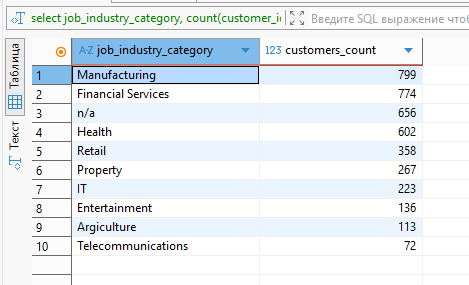

### 2. Найти общую сумму дохода (list_price*quantity) по всем подтвержденным заказам за каждый месяц по сферам деятельности клиентов. Отсортировать результат по году, месяцу и сфере деятельности.

```sql
SELECT EXTRACT(YEAR FROM o.order_date) AS year,
       EXTRACT(MONTH FROM o.order_date) AS month,
       c.job_industry_category,
       SUM(oi.quantity * p.list_price) AS total_revenue
FROM public.orders o
JOIN public.customer c ON o.customer_id = c.customer_id
JOIN public.order_items oi ON o.order_id = oi.order_id
JOIN public.product p ON oi.product_id = p.product_id
WHERE o.order_status = 'Approved'
      AND c.job_industry_category IS NOT NULL
GROUP BY EXTRACT(YEAR FROM o.order_date),
         EXTRACT(MONTH FROM o.order_date),
         c.job_industry_category
ORDER BY year, 
         month, 
         c.job_industry_category;
```

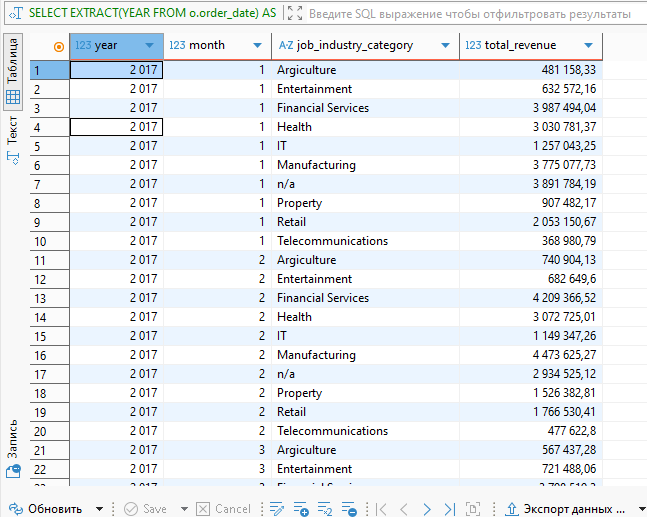

### 3. Вывести количество уникальных онлайн-заказов для всех брендов в рамках подтвержденных заказов клиентов из сферы IT. Включить бренды, у которых нет онлайн-заказов от IT-клиентов, — для них должно быть указано количество 0.

```sql
SELECT 
    p.brand,
    COUNT(DISTINCT o.order_id) AS unique_online_orders
FROM public.product p
LEFT JOIN (
    SELECT oi.product_id, o.order_id
    FROM public.order_items oi
    JOIN public.orders o ON oi.order_id = o.order_id
    JOIN public.customer c ON o.customer_id = c.customer_id
    WHERE o.online_order = TRUE
      AND o.order_status = 'Approved'
      AND c.job_industry_category = 'IT'
) o ON p.product_id = o.product_id
GROUP BY p.brand
ORDER BY unique_online_orders DESC;
```

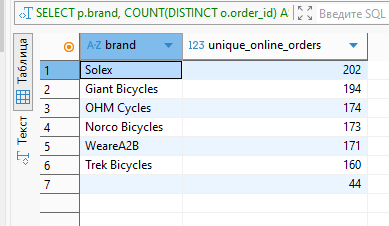

### 4. Найти по всем клиентам: сумму всех заказов (общего дохода), максимум, минимум и количество заказов, а также среднюю сумму заказа по каждому клиенту. Отсортировать результат по убыванию суммы всех заказов и количества заказов. Выполнить двумя способами: используя только GROUP BY и используя только оконные функции. Сравнить результат.

``` sql
--Группировка
SELECT 
    c.customer_id,
    c.first_name,
    c.last_name,
    SUM(oi.quantity * oi.item_list_price_at_sale) AS total_revenue,
    MAX(oi.quantity * oi.item_list_price_at_sale) AS max_amount,
    MIN(oi.quantity * oi.item_list_price_at_sale) AS min_amount,
    COUNT(DISTINCT o.order_id) AS orders_count,
    AVG(oi.quantity * oi.item_list_price_at_sale) AS avg_amount
FROM public.customer c
JOIN public.orders o ON c.customer_id = o.customer_id
JOIN public.order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'Approved'
GROUP BY c.customer_id, 
         c.first_name, 
         c.last_name
ORDER BY total_revenue DESC, 
         orders_count DESC;

--Оконные функции
SELECT DISTINCT c.customer_id,
       c.first_name,
       c.last_name,
       SUM(oi.quantity * oi.item_list_price_at_sale) OVER (PARTITION BY c.customer_id) AS total_revenue,
       MAX(oi.quantity * oi.item_list_price_at_sale) OVER (PARTITION BY c.customer_id) AS max_amount,
       MIN(oi.quantity * oi.item_list_price_at_sale) OVER (PARTITION BY c.customer_id) AS min_amount,
       COUNT(DISTINCT o.order_id) OVER (PARTITION BY c.customer_id) AS orders_count,
       AVG(oi.quantity * oi.item_list_price_at_sale) OVER (PARTITION BY c.customer_id) AS avg_amount
FROM public.customer c
JOIN public.orders o ON c.customer_id = o.customer_id
JOIN public.order_items oi ON o.order_id = oi.order_id
WHERE o.order_status = 'Approved'
ORDER BY total_revenue DESC, 
         orders_count DESC;
```

Результат одинаковый, но анализ запросов показал различия:  
Группировка:  
Execution time: 67.301 ms  
Planning time: 55.446 ms  
Memory: 6926K bytes avg × 32 workers  
Rows processed: 3492 final rows  

Оконные функции:  
Execution time: 51.916 ms  
Planning time: 2.098 ms  
Memory: 4973K bytes avg × 32 workers  
Rows processed: 3492 final rows

Итог: В данном случае использование оконных функций выигрывает времени выполнения, планирования и по потреблению памяти.

Группировка 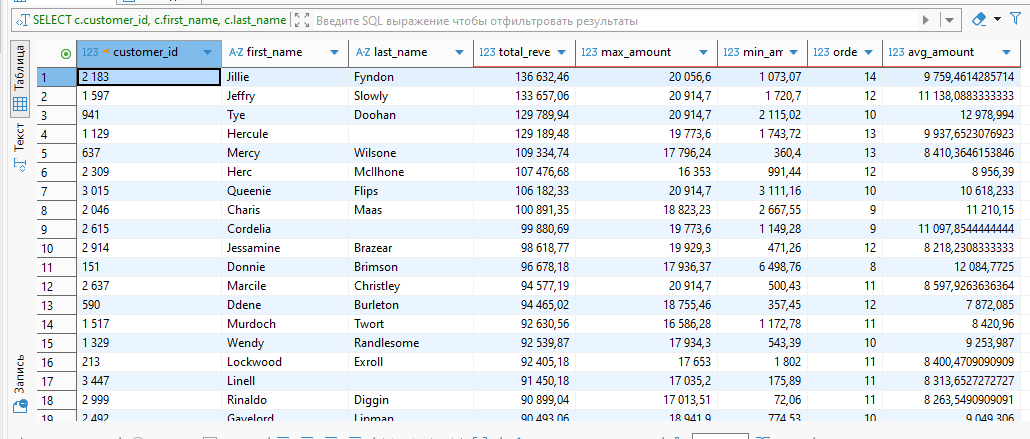

Оконные функции 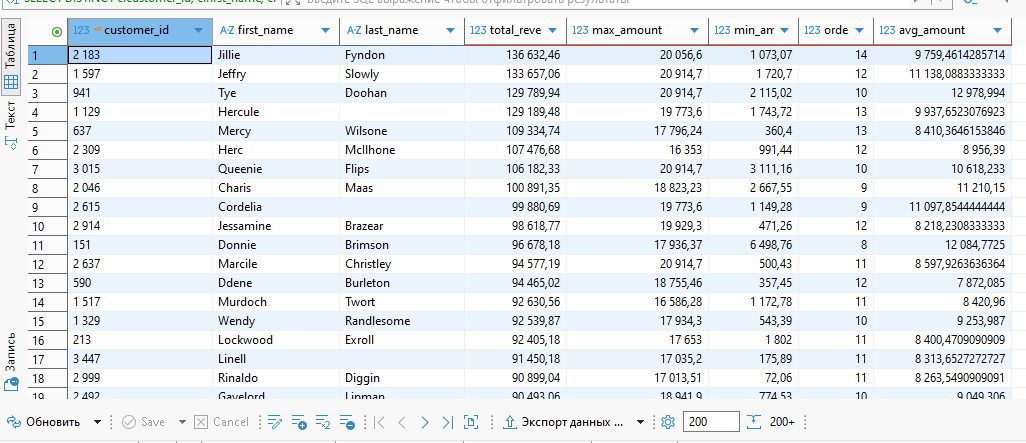

### 5. Найти имена и фамилии клиентов с топ-3 минимальной и топ-3 максимальной суммой транзакций за весь период (учесть клиентов, у которых нет заказов, приняв их сумму транзакций за 0).

```sql
WITH customer AS (
    SELECT c.first_name,
           c.last_name,
           COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) AS total_amount
    FROM public.customer c
    LEFT JOIN public.orders o ON c.customer_id = o.customer_id
    LEFT JOIN public.order_items oi ON o.order_id = oi.order_id
    WHERE o.order_id IS NULL 
          OR o.order_status = 'Approved'
    GROUP BY c.customer_id, 
             c.first_name, 
             c.last_name
),
rank AS (
    SELECT first_name,
           last_name,
           total_amount,
           ROW_NUMBER() OVER (ORDER BY total_amount ASC) AS min_rank,
           ROW_NUMBER() OVER (ORDER BY total_amount DESC) AS max_rank
    FROM customer
)
SELECT first_name,
       last_name
FROM rank
WHERE min_rank <= 3 
      OR max_rank <= 3
ORDER BY total_amount;
```

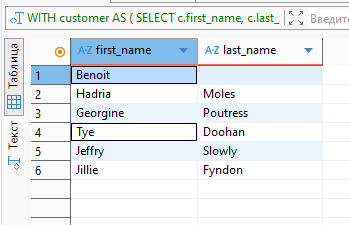

### 6. Вывести только вторые транзакции клиентов (если они есть) с помощью оконных функций. Если у клиента меньше двух транзакций, он не должен попасть в результат.

``` sql
WITH ranked_orders AS (
    SELECT o.customer_id,
           c.first_name,
           c.last_name,
           o.order_id,
           o.order_date,
           oi.quantity * oi.item_list_price_at_sale AS order_amount,
           ROW_NUMBER() OVER (PARTITION BY o.customer_id ORDER BY o.order_date, o.order_id) AS transaction_rank
    FROM public.orders o
    JOIN public.customer c ON o.customer_id = c.customer_id
    JOIN public.order_items oi ON o.order_id = oi.order_id
    WHERE o.order_status = 'Approved'
)
SELECT customer_id,
       first_name,
       last_name,
       order_id,
       order_date,
       order_amount
FROM ranked_orders
WHERE transaction_rank = 2;
```   

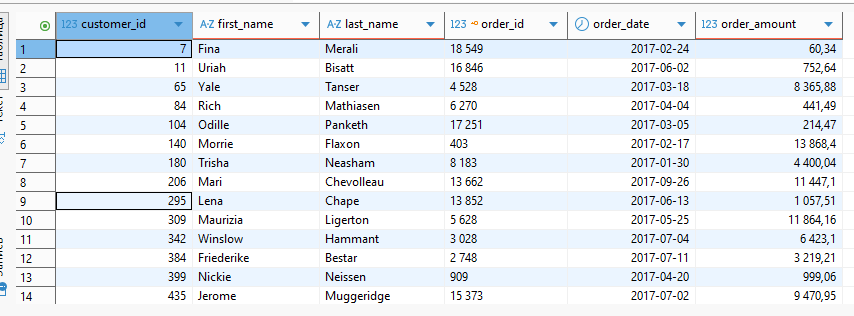

### 7. Вывести имена, фамилии и профессии клиентов, а также длительность максимального интервала (в днях) между двумя последовательными заказами. Исключить клиентов, у которых только один или меньше заказов.

``` sql
WITH order_intervals AS (
    SELECT c.customer_id,
           c.first_name,
           c.last_name,
           c.job_title,
           LEAD(o.order_date) OVER (PARTITION BY c.customer_id ORDER BY o.order_date) - o.order_date AS days_between_orders
    FROM public.customer c
    JOIN public.orders o ON c.customer_id = o.customer_id
    WHERE o.order_status = 'Approved'
)
SELECT first_name,
       last_name,
       job_title,
       MAX(days_between_orders) AS max_interval_days
FROM order_intervals
WHERE days_between_orders IS NOT NULL
GROUP BY customer_id, 
         first_name,
         last_name, 
         job_title
ORDER BY max_interval_days DESC;
```

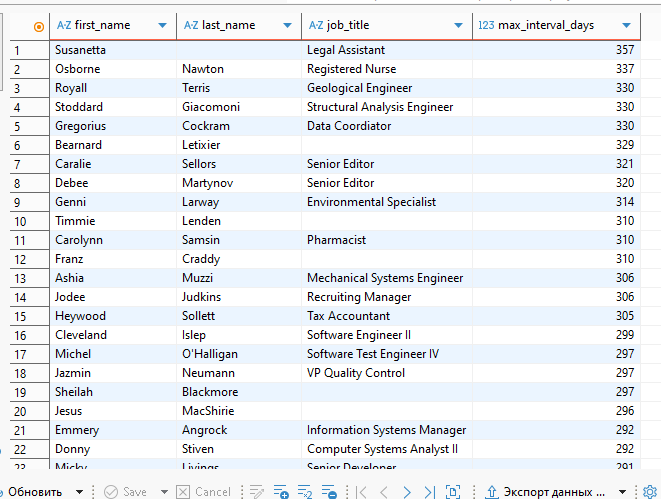

### 8. Найти топ-5 клиентов (по общему доходу) в каждом сегменте благосостояния (wealth_segment). Вывести имя, фамилию, сегмент и общий доход. Если в сегменте менее 5 клиентов, вывести всех.

``` sql
WITH customer_revenue AS (
    SELECT 
        c.customer_id,
        c.first_name,
        c.last_name,
        c.wealth_segment,
        COALESCE(SUM(oi.quantity * oi.item_list_price_at_sale), 0) AS total_revenue
    FROM public.customer c
    LEFT JOIN public.orders o ON c.customer_id = o.customer_id
    LEFT JOIN public.order_items oi ON o.order_id = oi.order_id
    WHERE o.order_id IS NULL OR o.order_status = 'Approved'
    GROUP BY c.customer_id, c.first_name, c.last_name, c.wealth_segment
),
ranked_customers AS (
    SELECT 
        customer_id,
        first_name,
        last_name,
        wealth_segment,
        total_revenue,
        ROW_NUMBER() OVER (
            PARTITION BY wealth_segment 
            ORDER BY total_revenue DESC
        ) AS rank_in_segment
    FROM customer_revenue
)
SELECT 
    first_name,
    last_name,
    wealth_segment,
    total_revenue
FROM ranked_customers
WHERE rank_in_segment <= 5
ORDER BY wealth_segment, rank_in_segment;
```

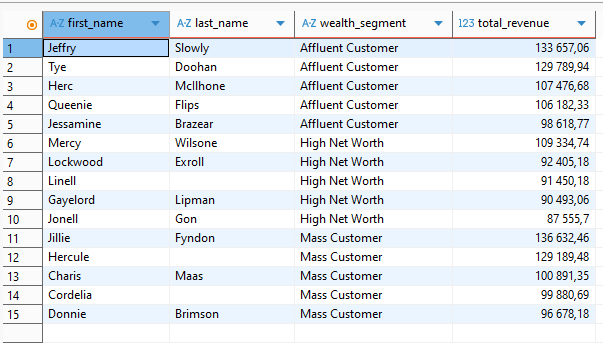